In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math
import time

from Data import *
from nets.MLP import MLP
from flows import RealNVPFlow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device = 'cpu'

## Base distribution

In [4]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device)) #, validate_args=False)

In [5]:
batch_size = 32
datapath = '/home/mvasist/ProbAI/NormFlows/datasets/'
dset = 'two_moons'
Data = Data(datapath + dset +'.csv')
d = Data.read_csv().to(device)

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

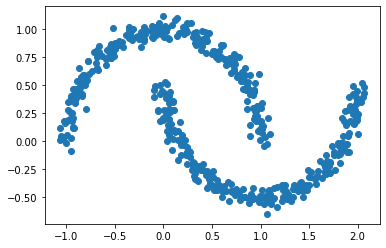

In [6]:
Data.plot_scatter()

## RealNVP

In [7]:
net = MLP(ip = 1, out = 2)
# net
def make_net():
    return nn.Sequential(nn.Linear(1,32), nn.GELU(),
#                          nn.Linear(32,64), nn.GELU(),
#                          nn.Linear(64,64), nn.GELU(),
                         nn.Linear(32,32), nn.GELU(),
                         nn.Linear(32,2))
        
        
#         nn.Linear(1,32), nn.GELU(),
#                          nn.Linear(32,32), nn.GELU(),
#                          nn.Linear(32,2)) 

In [8]:
flow_realnvp = RealNVPFlow(net = make_net(), dim= 3, device = device).to(device)
print(flow_realnvp.flow)

ModuleList(
  (0): CouplingBijection(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): GELU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): GELU()
      (4): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (1): ReverseBijection()
  (2): CouplingBijection(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): GELU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): GELU()
      (4): Linear(in_features=32, out_features=2, bias=True)
    )
  )
)


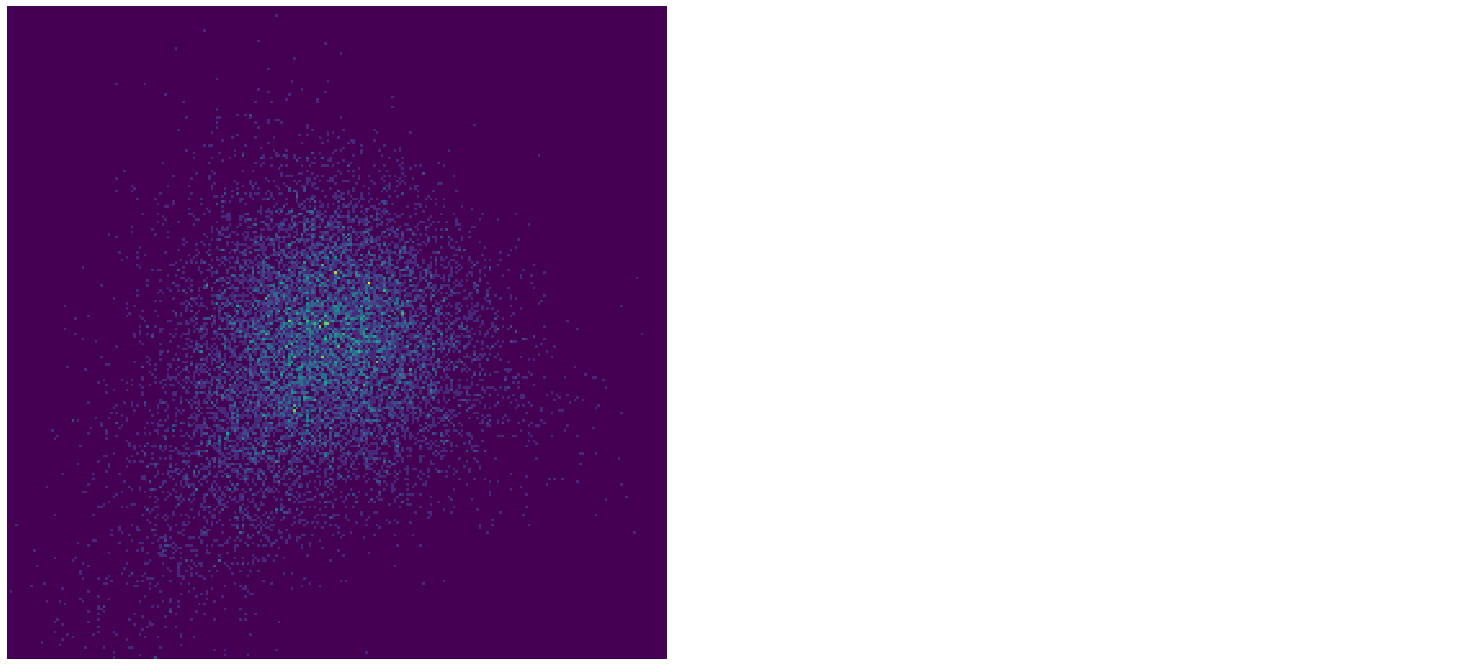

In [9]:
z_samples = flow_realnvp.sample(12800)

fig = Data.plot_samples(z_samples, None, None, None)
# fig.savefig('results/NVP_two_moons_before.pdf')

In [11]:
start  = time.time()

#Train

optimizer = torch.optim.Adam(flow_realnvp.parameters(), lr=0.5e-3) 
epochs = 1000

print('Training...')
flow_realnvp = flow_realnvp.train()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        x = x.to(device).type(torch.float32)
        optimizer.zero_grad()
        z, log_det = flow_realnvp.flow_outputs(x)
#         if torch.isnan(z).any() : 
#             continue
#         print(z)
        log_prob = base_dist().log_prob(z).sum(1) + log_det
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    if epoch %10 == 0 :    
        print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
    if epoch % 5 == 0:
        torch.save(flow_realnvp, 'models/RealNVP_'+ dset +'_model.pt')
flow_realnvp = flow_realnvp.eval()

end = time.time()
print('Training takes ', (end-start)/3600, ' hrs')

Training...
Epoch: 1/1000, Loss: 1.887
Epoch: 11/1000, Loss: 1.840
Epoch: 21/1000, Loss: 1.810
Epoch: 31/1000, Loss: 1.807
Epoch: 41/1000, Loss: 1.881
Epoch: 51/1000, Loss: 1.777
Epoch: 61/1000, Loss: 1.781
Epoch: 71/1000, Loss: 1.786
Epoch: 81/1000, Loss: 1.743
Epoch: 91/1000, Loss: 1.745
Epoch: 101/1000, Loss: 1.751
Epoch: 111/1000, Loss: 1.688
Epoch: 121/1000, Loss: 1.713
Epoch: 131/1000, Loss: 1.682
Epoch: 141/1000, Loss: 1.654
Epoch: 151/1000, Loss: 1.670
Epoch: 161/1000, Loss: 1.690
Epoch: 171/1000, Loss: 1.670
Epoch: 181/1000, Loss: 1.642
Epoch: 191/1000, Loss: 1.601
Epoch: 201/1000, Loss: 1.593
Epoch: 211/1000, Loss: 1.603
Epoch: 221/1000, Loss: 1.587
Epoch: 231/1000, Loss: 1.560
Epoch: 241/1000, Loss: 1.546
Epoch: 251/1000, Loss: 1.606
Epoch: 261/1000, Loss: 1.555
Epoch: 271/1000, Loss: 1.561
Epoch: 281/1000, Loss: 1.561
Epoch: 291/1000, Loss: 1.535
Epoch: 301/1000, Loss: 1.553
Epoch: 311/1000, Loss: 1.536
Epoch: 321/1000, Loss: 1.515
Epoch: 331/1000, Loss: 1.533
Epoch: 341/10

In [18]:
print('Training takes ', (end-start)/3600, ' hrs')

Training takes  0.6437241856257121  hrs


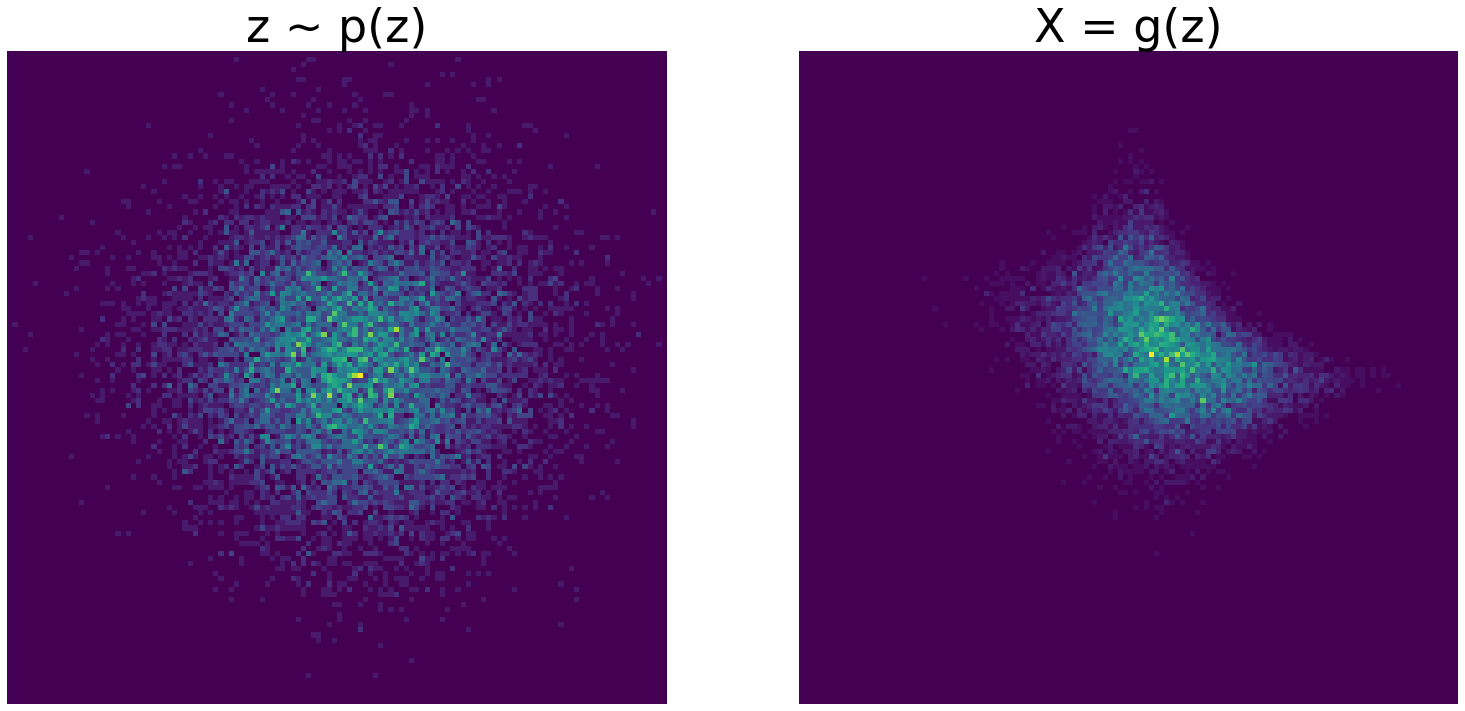

In [12]:
x_dash = flow_realnvp.sample(12800)

fig = Data.plot_samples(z_samples, x_dash, r'z ~ p(z)', r'X = g(z)', 128)
# fig.savefig('results/NVP_'+ dset +'_1.pdf')

# fig = Data.plot_samples(d, flow_realnvp.sample(128000))
# fig.savefig('results/NVP_two_moons_after.pdf')

## Back to prior space

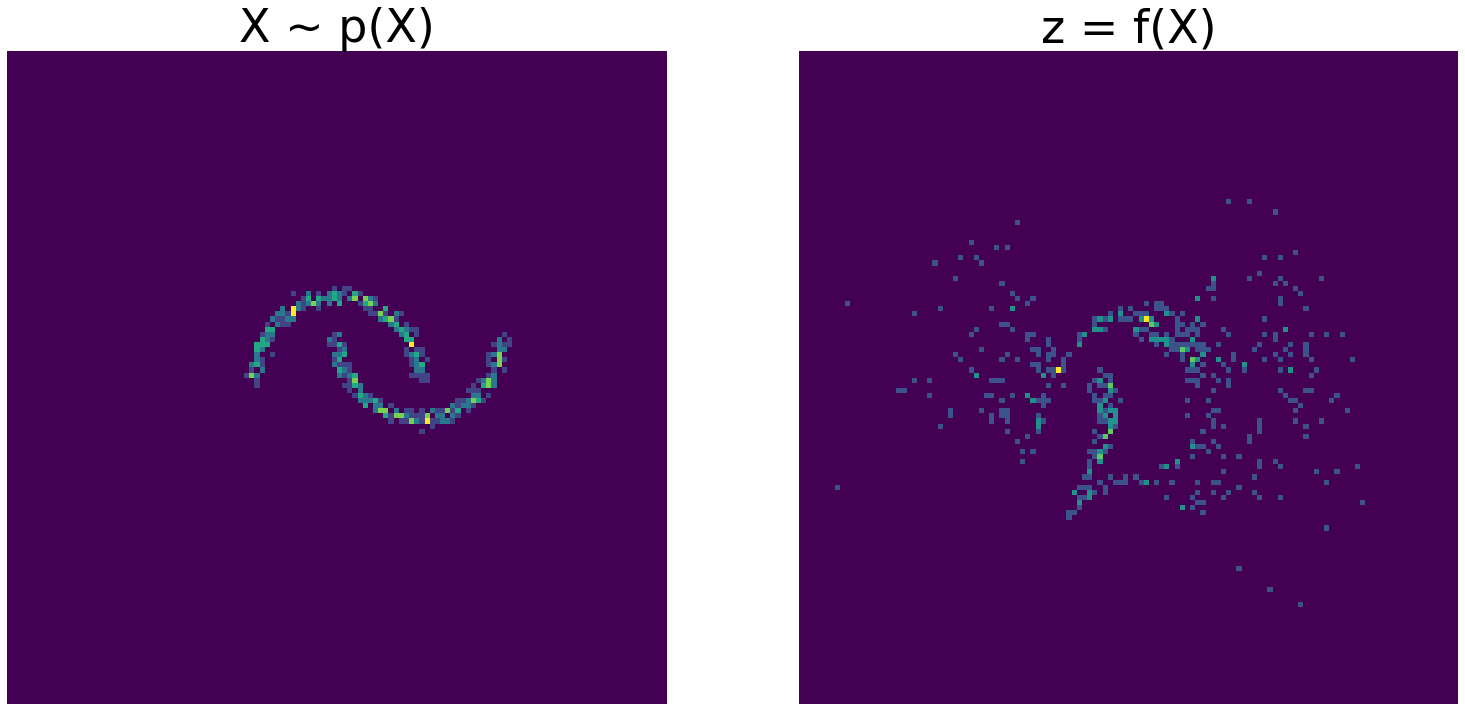

In [13]:
z_dash,_ = flow_realnvp.flow_outputs(d)
fig = Data.plot_samples(d, z_dash, r'X ~ p(X)', r'z = f(X)', 128)
# fig.savefig('results/NVP_'+ dset +'_2.pdf')



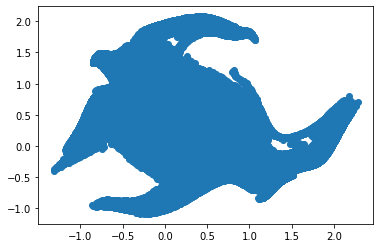

In [17]:
plt.scatter(x_dash[:,0].detach().cpu().numpy(), x_dash[:,1].detach().cpu().numpy())

(-10.0, 15.0)

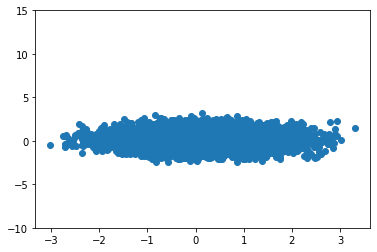

In [18]:
plt.scatter(z_samples[:,0].detach().cpu().numpy(), z_samples[:,1].detach().cpu().numpy())
plt.ylim(-10,15)